In [ ]:
#Project Title - Movie Predictor Algorithm 
#Developer name: Yvar Joseph

In [1]:
import pandas as pd
import sqlalchemy
import sqlalchemy as db
import sqlite3
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import unittest

In [2]:
class Database(object):
      def __init__(self, uri=''):
          self.__uri = uri

      def set_uri(self, db_uri):
          """
          function name: set_uri
          parameters: db_uri
          purpose: set_uri is designed to set the database uri for the 
                   establishment of a proper connection
          """
          if not isinstance(db_uri, str):
              raise Exception('Invalid database uri')
          else:
              self.__uri = db_uri
           
      def get_uri(self):
          return self.__uri
    

In [3]:
class Schema(Database):
    def __init__(self, uri='', schema_name=''):
        super().__init__(uri)
        self.__schema_name = schema_name
  
    def set_schema_name(self, sc_name):
        """
        function name: set_schema_name
        arguments: sc_name (representative of the schema name)
        purpose: designed to provide the schema a name
        """
        if not isinstance(sc_name, str):
              raise Exception('Invalid schema name')
        if len(sc_name) > 128:
              raise Exception('Schema name has exceeded limit')
        else:
            self.__schema_name = sc_name

    def get_schema_name(self):
        return self.__schema_name

    def database_connection(self):
            """
            function name: database_connection
            arguments: none
            purpose: creation of a persistent database connection
            returns: connection, metadata and engine
                     connection: connection to a database
                     metadata: the database's metadata
                     engine: the database's engine
            """
            engine = db.create_engine(self.get_uri())
            metadata = db.MetaData()
            # Connect to database
            try:
                connection = engine.connect()
            except Exception:
                print(f'Error: failed database connection encountered\n\
                       Invalid uri: {uri}')
            return connection, metadata, engine



    def create_table(self, name, meta_data, columns = []):
        """
        function name: create_table
        arguments: name, meta_data, columns
        purpose: designed for dynamic table creation
        returns: table (the created table)
        """
        table = db.Table(name,
                meta_data,
                *columns,
                extend_existing=True)
        return table

    def create_column(self, name, data_type, primary_key=False, nullable=False):
        """
        function name: create_column
        arguments: name, data_type, primary_key, nullable
        purpose: designed for dynamic column creation when
                 creating a table.
        returns: column (the created column)
        """
        column = db.Column(name,
                          data_type,
                          primary_key=primary_key,
                          nullable=nullable)
        return column

    def create_all_tables(self, metadata, connection):
        """
        function name: create_all_tables
        arguments: metadata, connection
        purpose: producing all tables, and their meta data, 
                finally displaying the created table names
        """
        metadata.create_all(engine)
        #display all tables
        for table in metadata.tables:
            print(f'Table: {table}')

    def insert_data(self, table, data_list, connection):
        """
        function name: insert_data
        arguments: table, data_list, connection
        purpose: used to insert data into a provided table,
                 according to the amount of data within the data list
                 and the respective connection provided to perform query
                 execution
        """
        sql_query = db.insert(table)
        try:
            result = connection.execute(sql_query, data_list)
        except Exception as e:
            print('An error occurred when inserting data')
            print(e)

    def select_data(self, table, connection):
        """
        function name: select_data
        arguments: table, connection
        purpose: designed for the selection of all samples in a table
        """
        select_table = table.select()
        try:
            dataset_data = connection.execute(select_table)
        except Exception:
            print('Error fetching data')
        else:
            for data in dataset_data:
                print(data)



In [4]:
class LeastSquares(object):
    def normal_equations(self, x, y):
        """
        function name: normal_equations
        parameters: x, y (representative of Series data)
        purpose: making use of normal equations to find the line of best fit for a
                 linear model using the least-square approach.
        Return values: a0 and a1 
                       where a0 is the intercept value of the linear model
                       and a1 is the gradient of the linear model of best fit
        """
        if  (x is None or y is None):
            raise Exception('One of the datasets is empty')
        if (len(x) < 2 or len(y) < 2):
            raise Exception('Datasets must have at least 2 values')
        else:
            n = len(x)
            x_sum = np.sum(x)
            y_sum = np.sum(y)
            sum_xy = np.sum(x * y)
            x_sum_sq = np.sum(x**2)
        
            #Establish normal equations and solve for a0 and a1
            a = np.array([[n,x_sum], [x_sum, x_sum_sq]]) 
            b = np.array([y_sum, sum_xy])
            result = np.linalg.solve(a,b)
            a0 = np.round(result[0],3)
            a1 = np.round(result[1],3)
        return a0,a1 

    def squared_deviations(self, a0, a1, x, y):
        """
        function name: squared_deviations
        parameters: a0, a1, x, y
        purpose: finds the squared deviations between the predicted y values and
                 actual y parameters of a dataset.
        returns: diff, the deviation (error) between the actual and predicted y values
        """
        n = len(x)
        diff = 0
        for i in range(n):
            diff += round((y[i] - (a0 + x[i] * a1))**2, 2)
        return diff

    def derive_deviations_y(self, train, ideal):
        """
        function name: derive_deviations_y
        parameters: train, ideal
        purpose: finds the deviations between the training set's y values and the ideal set's y values using the 
                 least-squares method
        returns: selected_features
                 selected_features: are the features/columns of best fit out of the 50 for the training data's y values
        """
        min_deviations = []
        max_deviations = []
        min_deviation_indices = []
    
        for train_column in train.columns: #Y1
            deviations = []
            for ideal_column in ideal.columns:
                a0, a1 = self.normal_equations(ideal[ideal_column], train[train_column]) #Y1
                deviation = self.squared_deviations(a0, a1,ideal[ideal_column], train[train_column]) #Y1....Y50 (deviations)
                deviations.append(deviation)
            deviation_series = pd.Series(deviations)
            min_deviation = deviation_series.min()
            min_index = deviation_series.idxmin()
            min_deviations.append(min_deviation)
            min_deviation_indices.append(min_index)
        selected_features = [ideal.columns[index] for index in min_deviation_indices]
        return selected_features

    def max_deviations_func(self, train_set, ideal_chosen):
        """
        function name: max_deviations_func
        parameters: train_set, ideal_chosen
        purpose: calculates the maximum deviation from the training set with respect
                 to the four ideal functions chosen for it.
        returns: max_deviations
                 where max_deviations is a list of the 4 maximum deviations per difference
                 of the four training functions and the chosen ideal functions
        """
        max_deviations = []
        for i in range(len(ideal_chosen.columns)):
            deviation = np.max(abs(train_set.iloc[:, i] - ideal_chosen.iloc[:, i]))
            max_result = deviation * np.sqrt(2)
            max_deviations.append(max_result)
        return max_deviations

In [5]:
class Predictor(LeastSquares):
    def y_test_pred(self, test_set):
        """
        function name: y_test_pred
        arguments: dataset
        purpose: calculates the predicted y values for each x variable
                 in the test dataset via regression
        returns: a list of predicted y values
        """
        x_test = test_set['x']
        y_test = test_set['y']
        y_preds = []
        a0,a1 = self.normal_equations(x_test, y_test)
        for x in x_test:
            y_pred = a0 + a1 * x
            y_preds.append(y_pred)
        return y_preds

    def prediction_error(self, y_preds, ideal_set, max_deviations, test_set):
        """
        function name: prediction_error
        arguments: y_preds, ideal_set, max_deviations
        purpose: calculates the difference between the predicted y values for each x-y 
                 pair, and then identifies which of those x-y pair values can be linked
                 to the ideal chosen y values.
        returns: a list of the ideal function names to which the x-y pairs are linked to.
        """ 
        x = test_set['x']
        y = test_set['y']
        selected_features = {}
        selected_list = []
        for i in range(len(y_preds)):
            for index, y_ideal in enumerate(ideal_set.columns):
                y_error = abs(y_preds[i] - ideal_set.loc[index,y_ideal])
                if y_error < max_deviations[index]:
                    selected = (x[i], y[i], y_error, y_ideal)
                    selected_list.append(selected)
        return selected_list

In [6]:
class DataCleanser(object):
    def null_checker(self, csv_file):
        """
        function name: null_checker
        arguments: csv_file
        purpose: designed to find null values in all features of a csv file
        returns: null_count, returns the number of null values in the csv file
        """
        data_df = pd.read_csv(csv_file)
        null_count = data_df.apply(lambda x: sum(x.isnull()), axis=0) 
        return null_count

    def get_feature_info(self, csv_file):
        """
        function name: get_feature_info
        arguments: csv_file
        purpose: designed to find info of a csv file, such as variables, data types, etc
        returns: info, a comprehensive list of all important aspects of the file
        """
        data_df = pd.read_csv(csv_file)
        return data_df.info()  

In [7]:
schema = Schema()
schema.set_uri('sqlite:///newdb.sqlite')
schema.set_schema_name('Personal Schema')
conn, meta, engine = schema.database_connection()

In [22]:
# #Create test table for table creation verif
table = schema.create_table("Test_table", meta, [schema.create_column("first_name",
                                                      db.String(50)),
                                         schema.create_column("last_name", db.String(50)),
                                         schema.create_column("age", db.Integer),
                                         schema.create_column("date_of_birth", db.Date)])
schema.create_all_tables(meta, engine)


Table: Test_table


In [8]:
#Training dataset table creation
training_table = schema.create_table("training_table", meta, [schema.create_column("x", db.Float),
                                                 schema.create_column("y1", db.Float),
                                                 schema.create_column("y2", db.Float),
                                                 schema.create_column("y3", db.Float),
                                                 schema.create_column("y4", db.Float)])

In [9]:
#Table 3 (test deviations) table creation
test_deviation_table = schema.create_table('test_deviations', meta, [
                                        schema.create_column('x', db.Float),
                                        schema.create_column('y', db.Float),
                                        schema.create_column('Delta Y', db.Float),
                                        schema.create_column('No. ideal func', db.String(3))])

In [10]:
#Ideal dataset table creation
columns_ideal = []
for i in range(0, 51):
   if i == 0:
      columns_ideal.append(schema.create_column("x", db.Float))
   else:
       columns_ideal.append(schema.create_column("y" + str(i), db.Float))
    
ideal_table = schema.create_table("ideal_functions", meta, columns_ideal)

schema.create_all_tables(meta, engine)

Table: training_table
Table: test_deviations
Table: ideal_functions


In [53]:
#Data cleansing ideal_functions
cleanser = DataCleanser()
training_null_count = cleanser.null_checker('train.csv')
ideal_null_count = cleanser.null_checker('ideal.csv')
print(f'Training set null count\n: {training_null_count}')
print(f'Ideal set null count\n: {ideal_null_count}')

Training set null count
: x     0
y1    0
y2    0
y3    0
y4    0
dtype: int64
Ideal set null count
: x      0
y1     0
y2     0
y3     0
y4     0
y5     0
y6     0
y7     0
y8     0
y9     0
y10    0
y11    0
y12    0
y13    0
y14    0
y15    0
y16    0
y17    0
y18    0
y19    0
y20    0
y21    0
y22    0
y23    0
y24    0
y25    0
y26    0
y27    0
y28    0
y29    0
y30    0
y31    0
y32    0
y33    0
y34    0
y35    0
y36    0
y37    0
y38    0
y39    0
y40    0
y41    0
y42    0
y43    0
y44    0
y45    0
y46    0
y47    0
y48    0
y49    0
y50    0
dtype: int64


In [23]:
#Check data type information for datasets
print(cleanser.get_feature_info('train.csv'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       400 non-null    float64
 1   y1      400 non-null    float64
 2   y2      400 non-null    float64
 3   y3      400 non-null    float64
 4   y4      400 non-null    float64
dtypes: float64(5)
memory usage: 15.8 KB
None


In [24]:
print(cleanser.get_feature_info('ideal.csv'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       400 non-null    float64
 1   y1      400 non-null    float64
 2   y2      400 non-null    float64
 3   y3      400 non-null    float64
 4   y4      400 non-null    float64
 5   y5      400 non-null    float64
 6   y6      400 non-null    float64
 7   y7      400 non-null    float64
 8   y8      400 non-null    float64
 9   y9      400 non-null    float64
 10  y10     400 non-null    float64
 11  y11     400 non-null    float64
 12  y12     400 non-null    float64
 13  y13     400 non-null    float64
 14  y14     400 non-null    float64
 15  y15     400 non-null    float64
 16  y16     400 non-null    float64
 17  y17     400 non-null    float64
 18  y18     400 non-null    float64
 19  y19     400 non-null    float64
 20  y20     400 non-null    float64
 21  y21     400 non-null    float64
 22  y2

In [11]:
#Data insertion into tables
train_data_list = []
ideal_data_list = []
with open('train.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        train_data_list.append(row)

with open('ideal.csv', newline='') as idealcsv:
     reader = csv.DictReader(idealcsv)
     for row in reader:
         ideal_data_list.append(row)

In [12]:
#Inserting data into training table
training_result = schema.insert_data(training_table, train_data_list, conn)

In [13]:
#Insert data into ideal table
ideal_result = schema.insert_data(ideal_table,ideal_data_list, conn)

In [14]:
df_train = pd.read_sql('SELECT * FROM training_table', conn)

In [15]:
df_ideal = pd.read_sql('SELECT * FROM ideal_functions', conn)

In [16]:
#Finding the least square error
y_train = df_train.drop(columns=['x'])
y_ideal = df_ideal.drop(columns=['x'])

In [17]:
least_squares = LeastSquares()
selected_items = least_squares.derive_deviations_y(y_train, y_ideal)

In [18]:
ideal_selected = pd.DataFrame(df_ideal[selected_items])
ideal_selected.head()

,y42,y41,y12,y48
0,40.204040,-40.456474,-58.0,-0.186278
1,40.048590,-40.233820,-57.7,-0.215690
2,39.890660,-40.006836,-57.4,-0.236503
3,39.729824,-39.775787,-57.1,-0.247887
4,39.565693,-39.540980,-56.8,-0.249389


In [19]:
# #importing test data
test_data = pd.read_csv('test.csv')

In [20]:
predictor = Predictor()
max_deviations = least_squares.max_deviations_func(y_train, ideal_selected)
test_model_pred = predictor.y_test_pred(test_data)
test_model_err = predictor.prediction_error(test_model_pred, ideal_selected,
                                          max_deviations, test_data)

In [21]:
print(test_model_err)

[(0.3, 1.2151024, 57.7258, 'y12'), (0.3, 1.2151024, 0.57368749, 'y48'), (-8.7, -16.843908, 52.3618, 'y12'), (-19.2, -37.17087, 46.1038, 'y12'), (-11.0, -20.263054, 50.991, 'y12'), (0.8, 1.4264555, 58.0238, 'y12'), (-10.4, -2.007094, 51.3486, 'y12'), (-15.0, -0.20536347, 48.607, 'y12'), (-7.6, -39.4954, 53.0174, 'y12'), (-19.8, -19.915014, 45.7462, 'y12'), (-9.5, -9.652251, 51.885, 'y12'), (-8.8, 16.571745, 52.3022, 'y12'), (-15.4, 29.490164, 48.3686, 'y12'), (-17.9, 1.1692159, 46.8786, 'y12'), (-3.1, -2.7701359, 55.6994, 'y12'), (-10.1, -40.44977, 51.5274, 'y12'), (-11.8, 24.606413, 50.5142, 'y12'), (-14.3, -30.492392, 49.0242, 'y12'), (-18.8, 13.410461, 46.3422, 'y12'), (-2.8, -3.2989988, 55.8782, 'y12'), (-8.2, -16.575344, 52.6598, 'y12'), (2.8, -36.151726, 59.2158, 'y12'), (-4.0, -8.339117, 55.163, 'y12'), (-7.9, -0.21800028, 52.8386, 'y12'), (-7.3, -9.224243, 53.1962, 'y12'), (-9.1, -8.293134, 52.1234, 'y12'), (-4.5, -9.88685, 54.864999999999995, 'y12'), (-5.7, 2.4492908, 54.1498, 

In [22]:
deviations_data_list = []
for i in range(len(test_model_err)):
    data_dict = {'x': test_model_err[i][0],
                 'y': test_model_err[i][1],
                 'Delta Y': test_model_err[i][2], 
                 'No. ideal func':test_model_err[i][3]}
    deviations_data_list.append(data_dict) 

In [23]:
schema.insert_data(test_deviation_table, deviations_data_list, conn)

In [24]:
test_dev = pd.read_sql('SELECT * FROM test_deviations', conn)
test_dev.head(n=15)

,x,y,Delta Y,No. ideal func
0,0.3,1.215102,57.725800,y12
1,0.3,1.215102,0.573687,y48
2,-8.7,-16.843908,52.361800,y12
3,-19.2,-37.170870,46.103800,y12
4,-11.0,-20.263054,50.991000,y12
5,0.8,1.426456,58.023800,y12
6,-10.4,-2.007094,51.348600,y12
7,-15.0,-0.205363,48.607000,y12
8,-7.6,-39.495400,53.017400,y12
9,-19.8,-19.915014,45.746200,y12


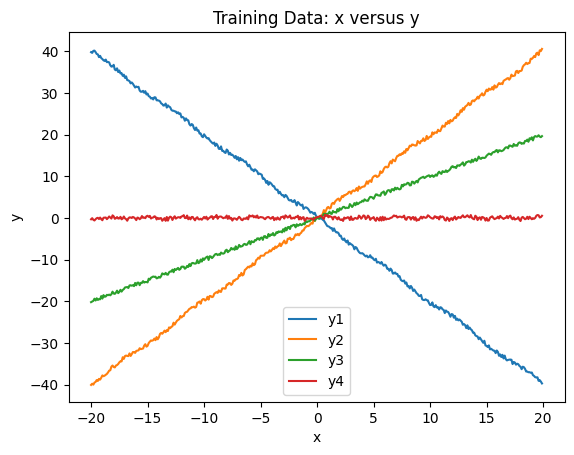

<Figure size 640x480 with 0 Axes>

In [34]:
#Visualizations

#Visualizing the training data 
plt.figure(1)
plt.plot(df_train['x'], df_train['y1'], label='y1')
plt.plot(df_train['x'], df_train['y2'], label='y2')
plt.plot(df_train['x'], df_train['y3'], label='y3')
plt.plot(df_train['x'], df_train['y4'], label='y4')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Data: x versus y')
plt.legend()
plt.show()
plt.clf()

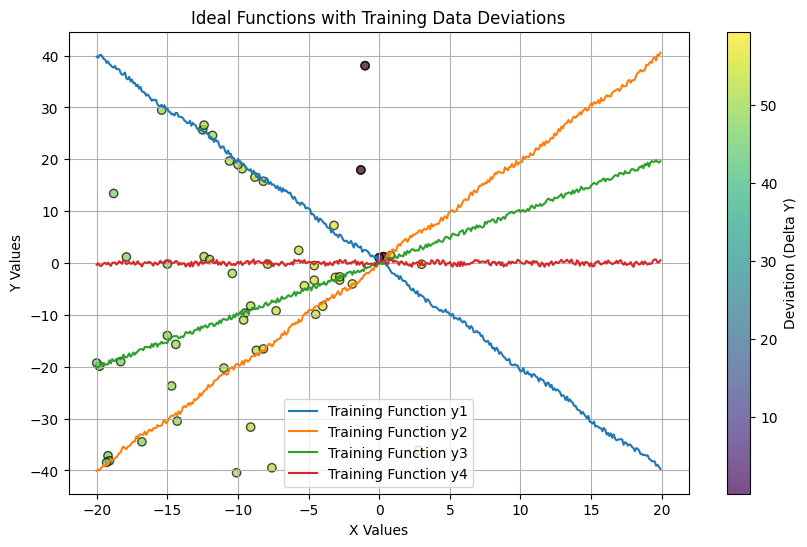

In [30]:
x_values = test_dev['x']
y_values = test_dev['y']
delta_y = test_dev['Delta Y']
ideal_funcs = test_dev['No. ideal func']

plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_values, y_values, c=delta_y, cmap='viridis', alpha=0.7, edgecolor='k')

# Plotting deviations
for i in range(1, 5): 
    plt.plot(df_train['x'], df_train[f'y{i}'], label=f'Training Function y{i}')

plt.colorbar(scatter, label='Deviation (Delta Y)')
plt.title('Ideal Functions with Training Data Deviations')
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.grid(True)
plt.legend()
plt.show()


In [86]:
#Unit tests
class TestPredictions(unittest.TestCase):
      def test_normal_equations(self):
          test_set = [4, 12, 15, 8]
          test_set_2 = []
          self.assertRaises(Exception, normal_equations, test_set, test_set_2)

      def test_normal_equations_empty_list(self):
          test_set = [4, 12, 15, 8]
          test_set_2 = [3]
          self.assertRaises(Exception, normal_equations, test_set, test_set_2)

      def test_normal_equations_result_a0(self):
          frequency = pd.Series([50,100,150,200,250,300,350])
          inductive = pd.Series([30,65,90,130,150,190,200])
          a0,a1 = normal_equations(frequency,inductive)
          expected = 5.0
          self.assertEqual(a0, expected)
          
      def test_normal_equations_result_a1(self):
          frequency = pd.Series([50,100,150,200,250,300,350])
          inductive = pd.Series([30,65,90,130,150,190,200])
          a0,a1 = normal_equations(frequency,inductive)
          expected = 0.586
          self.assertEqual(a1, expected)

      def test_squared_deviations(self):
          a0 = 3.0026
          a1 = 0.677
          x = [8, 3,2,10,11,3,6,5,6,8]
          y = [4,12,1,12,9,4,9,6,1,14]
          expected = 159.28
          self.assertAlmostEqual(squared_deviations(a0,a1,x,y), expected)

      def test_database_connection(self):
          false_uri = 'falsedatabase.sqlite'
          self.assertRaises(Exception, database_connection, false_uri)

      def test_y_predicted(self):
          x = [1,3,5,6]
          y = [2,4,10,1]
          test_dataset = pd.DataFrame({'x':x, 'y':y})
          expected_list = [3.085, 3.933, 4.781000000000001, 5.205]
          result = y_test_pred(test_dataset)
          self.assertTrue(expected_list==result)

      def test_prediction_error(self):
          y_pred_data = [2,4]
          y_ideal_data = pd.DataFrame({'y1':[1], 'y2':[3], 'y3':[4]})
          maximum_diff = [1,3,5]
          expected = [{2:('y1', 1)},
                     {2:('y2', 1)},
                     {2:('y3', 2)},
                     {4:('y2', 1)},
                     {4:('y3', 0)}]
          result =  prediction_error(y_pred_data, y_ideal_data, maximum_diff)    
          self.assertTrue(expected==result)
          
      
if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

........
----------------------------------------------------------------------
Ran 8 tests in 0.115s

OK
